# Importation des bibliothèques à utiliser

In [ ]:
# Importing functions and classes we'll use

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from warnings import catch_warnings
from warnings import filterwarnings
import keras
import sys
import scipy.stats
import json
import numpy.fft
import time
from decimal import Decimal
import math
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

# Importation du dataset

In [ ]:
df = pd.read_excel('/content/sample_data/new_dataset.xlsx')
node1_delay = df[['node1_delay']]

dataset = node1_delay.values

In [ ]:
df.head()

,instant,node1_delay,node2_delay,node3_delay,node1_cpu,node1_ram,node2_cpu,node2_ram,node3_cpu,node3_ram,node1_x,node1_y
0,2022-11-07 12:00:00,0.168295,0.250647,0.175589,0.36,0.7,0.30,0.7,0.80,0.7,3,1
1,2022-11-07 12:00:03,0.110052,0.242842,0.097456,0.69,0.4,0.50,0.5,0.17,0.7,1,5
2,2022-11-07 12:00:06,0.468962,0.242266,0.137896,0.93,0.6,0.73,0.7,0.83,0.7,2,1
3,2022-11-07 12:00:09,0.380637,0.169424,0.122439,0.30,0.7,0.59,0.4,0.62,0.4,0,0
4,2022-11-07 12:00:12,0.173749,0.189239,0.230444,0.44,0.7,0.68,0.3,0.33,0.4,0,3


# Description du dataset

In [ ]:
selected_columns = ['node1_delay', 'node2_delay', 'node3_delay', 'node1_ram', 'node2_ram', 'node3_ram', 'node1_cpu', 'node2_cpu', 'node3_cpu']

df[selected_columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
node1_delay,20000.0,0.323828,0.152275,0.059012,0.191918,0.324079,0.456506,0.586923
node2_delay,20000.0,0.200986,0.053737,0.107939,0.154545,0.200765,0.247665,0.294275
node3_delay,20000.0,0.215486,0.086349,0.065931,0.140327,0.215022,0.290110,0.364288
node1_ram,20000.0,0.548665,0.149550,0.300000,0.400000,0.500000,0.700000,0.800000
node2_ram,20000.0,0.550655,0.149939,0.300000,0.400000,0.600000,0.700000,0.800000
node3_ram,20000.0,0.548180,0.149552,0.300000,0.400000,0.500000,0.700000,0.800000
node1_cpu,20000.0,0.534699,0.252282,0.100000,0.310000,0.530000,0.760000,0.970000
node2_cpu,20000.0,0.536648,0.251351,0.100000,0.320000,0.540000,0.750000,0.970000
node3_cpu,20000.0,0.535996,0.251008,0.100000,0.320000,0.540000,0.750000,0.970000


# Implémentation du filtre du débruitage Moving Average

In [ ]:
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        self.correlations = R_t[:int(max_lag)].real / R_t[0].real

        # Find autocorrelation peaks
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))

def moving_average(data, _range):
    ret = np.cumsum(data)
    ret[_range:] = ret[int(_range):] - ret[:-int(_range)]
    return ret[int(_range) - 1:] / _range

def SMA(data, _range, slide):
    ret = moving_average(data, int(_range))[::int(slide)]
    return list(ret)

def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

# Importation du bibliothèque du modèle ESN

In [ ]:
def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.

    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s

    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.

        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states

        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

# Algorithm du trasfert des données en format tabulaire

In [ ]:
def create_multistep_dataset(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end]
            X.append(x_input)
            y.append(data[in_end:out_end])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# 1ère série d'expérimentations : Prédiction univarié d'un pas en avant:

## Node1 Delay

In [ ]:
pip install -q optuna

In [ ]:
import optuna
from optuna.samplers import TPESampler

In [ ]:
# Finding best params

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))


# Define the objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters to search

    n_reservoir = trial.suggest_int('n_reservoir', 10, 1000)   # -
    sparsity = trial.suggest_categorical('sparsity', [0.01, 0.1, 0.2, 0.3, 0.4, 0.5])   # -
    spectral_radius = trial.suggest_categorical('spectral_radius', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.25, 10.0])   # - spectral radius of W
    noise = trial.suggest_categorical('noise', [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])       # - Noise Set
    look_back = trial.suggest_int('look_back', 10, 500)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(temp_train, look_back, 1)
    validX, validY = create_multistep_dataset(valid, look_back, 1)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], validX.shape[1]))

    # Build and fit the ESN model

    model = ESN(n_inputs = look_back,
                n_outputs = 1,
                n_reservoir = n_reservoir,
                sparsity=sparsity,
                random_state=1234,
                spectral_radius=spectral_radius,
                noise = noise,
                teacher_scaling = 10)

    # Train and test our model
    pred_train = model.fit(trainX, trainY)
    predictions = model.predict(validX)
    predictions = np.array(predictions)

    # Evaluate the model on the validation set
    val_loss = np.sqrt(mean_squared_error(predictions, validY))

    return val_loss

# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Record the starting time to generate predictions
start_time = time.time()

# Run the optimization
study.optimize(objective, n_trials=100)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("ESN HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

# Print the best parameters and corresponding loss
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters: ", best_params)
print("Best Loss: ", best_loss)

[I 2023-08-28 16:00:21,637] A new study created in memory with name: no-name-2b59b04e-409a-486c-939e-8389e0af911f


Window Size:  10
17991 16192 1799 2000


[I 2023-08-28 16:00:48,802] Trial 0 finished with value: 0.016316154867311607 and parameters: {'n_reservoir': 774, 'sparsity': 0.01, 'spectral_radius': 0.9, 'noise': 0.004, 'look_back': 302}. Best is trial 0 with value: 0.016316154867311607.
[I 2023-08-28 16:01:00,613] Trial 1 finished with value: 0.01744803576345066 and parameters: {'n_reservoir': 543, 'sparsity': 0.5, 'spectral_radius': 1.1, 'noise': 0.002, 'look_back': 50}. Best is trial 0 with value: 0.016316154867311607.
[I 2023-08-28 16:01:08,293] Trial 2 finished with value: 0.017342060107036903 and parameters: {'n_reservoir': 494, 'sparsity': 0.1, 'spectral_radius': 0.1, 'noise': 0.006, 'look_back': 32}. Best is trial 0 with value: 0.016316154867311607.
[I 2023-08-28 16:01:32,751] Trial 3 finished with value: 0.016279930891696288 and parameters: {'n_reservoir': 963, 'sparsity': 0.01, 'spectral_radius': 0.7, 'noise': 0.008, 'look_back': 443}. Best is trial 3 with value: 0.016279930891696288.
[I 2023-08-28 16:01:37,789] Trial 4 f

done
ESN HyperParameters Tuning Elapsed Time : 439.59206 seconds
Best Parameters:  {'n_reservoir': 33, 'sparsity': 0.3, 'spectral_radius': 1.1, 'noise': 0.004, 'look_back': 261}
Best Loss:  0.01542489762734059


In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  10
17991 16192 1799 2000
harvesting states...
fitting...
training error:
0.015327274933862952
ESN Model Training Elapsed Time : 1.35922 seconds
ESN Model Generate predictions Elapsed Time : 0.10375 seconds
ESN Test RMSE : 0.01583
ESN Test MAE : 0.01362


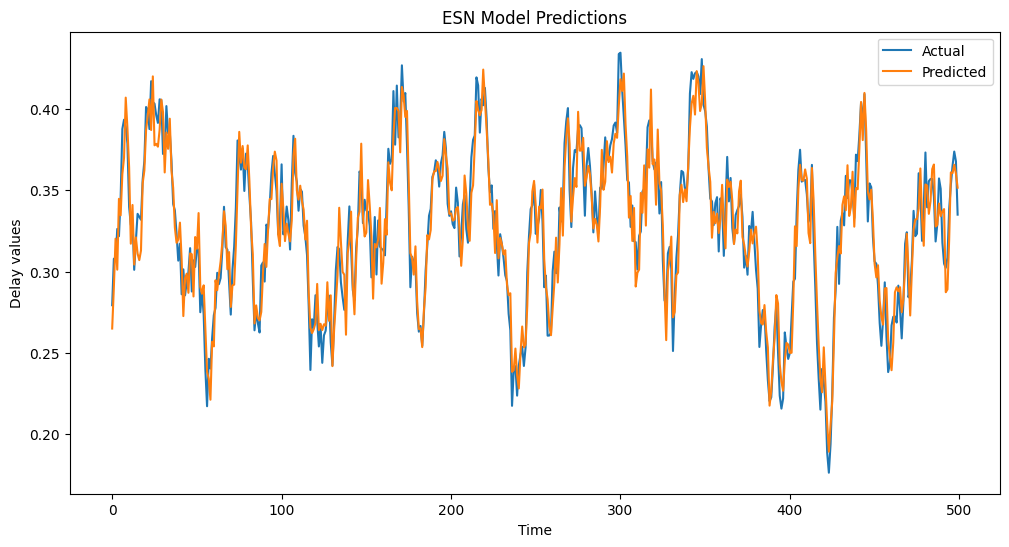

In [ ]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(testY[:500], label='Actual')
plt.plot(predictions[:500], label='Predicted')

plt.xlabel('Time')
plt.ylabel('Delay values')
plt.title('ESN Model Predictions')
plt.legend()
plt.show()

## Node2 Delay

In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

node1_delay = df[['node2_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  9
17992 2000
harvesting states...
fitting...
training error:
0.006025264368903009
ESN Model Training Elapsed Time : 1.43512 seconds
ESN Model Generate predictions Elapsed Time : 0.12429 seconds
ESN Test RMSE : 0.00604
ESN Test MAE : 0.00519


## Node3 Delay

In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

node1_delay = df[['node3_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  10
17991 2000
harvesting states...
fitting...
training error:
0.008722849734801795
ESN Model Training Elapsed Time : 1.31540 seconds
ESN Model Generate predictions Elapsed Time : 0.09139 seconds
ESN Test RMSE : 0.00889
ESN Test MAE : 0.00764


## Node1 RAM

In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

node1_delay = df[['node1_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  10
17991 2000
harvesting states...
fitting...
training error:
0.01509298541128334
ESN Model Training Elapsed Time : 1.32575 seconds
ESN Model Generate predictions Elapsed Time : 0.07063 seconds
ESN Test RMSE : 0.01536
ESN Test MAE : 0.01306


# 2ème série d'expérimentations : Prédiction univarié à plusieurs pas en avant:

## Stratégie Récursive

In [ ]:
# The recursive strategy for ESN Model

def recursive_strategy(model, X_row, n_steps):
    forecasts = []

    for i in range(n_steps):
        forecast = model.predict(np.array([X_row]))
        forecasts.append(forecast[0, 0])
        X_row = X_row.tolist()
        X_row.append(forecast[0, 0])
        X_row = X_row[1:]
        X_row = np.array(X_row)
    return forecasts

In [ ]:
def make_predictions(model, X, n_steps):
    predictions = []
    for i in tqdm(range(len(X)), desc="Progress"):
      row_forecasts = recursive_strategy(model, X[i, :], n_steps)
      predictions.append(row_forecasts)
    return predictions

In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time




print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

horizons = [2, 4, 6, 8, 10]

for horizon in horizons:
    print(f"=================== horizon = {horizon}======================")
    # Record the starting time to generate predictions
    predictions_start_time = time.time()

    testPredict = make_predictions(model, testX, horizon)

    # Record the ending time of generating predictions
    predictions_end_time = time.time()
    predictions_elapsed_time = predictions_end_time - predictions_start_time

    testPredict = np.array(testPredict)
    _, new_testY = create_multistep_dataset(test, look_back, horizon)

    testRMSE = np.sqrt(mean_squared_error(new_testY, testPredict[:len(new_testY), :]))
    testMAE = mean_absolute_error(new_testY, testPredict[:len(new_testY), :])

    print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
    print('ESN Test RMSE : %.5f' % (testRMSE))
    print('ESN Test MAE : %.5f' % (testMAE))

Window Size:  10
17991 2000
harvesting states...
fitting...
training error:
0.015327274933862952
ESN Model Training Elapsed Time : 2.08736 seconds
=================== horizon = 2======================


Progress: 100%|██████████| 1739/1739 [00:00<00:00, 4631.05it/s]


ESN Model Generate predictions Elapsed Time : 0.38343 seconds
ESN Test RMSE : 0.01946
ESN Test MAE : 0.01593
=================== horizon = 4======================


Progress: 100%|██████████| 1739/1739 [00:00<00:00, 2756.27it/s]


ESN Model Generate predictions Elapsed Time : 0.64136 seconds
ESN Test RMSE : 0.02519
ESN Test MAE : 0.01995
=================== horizon = 6======================


Progress: 100%|██████████| 1739/1739 [00:00<00:00, 1841.03it/s]


ESN Model Generate predictions Elapsed Time : 0.95032 seconds
ESN Test RMSE : 0.02974
ESN Test MAE : 0.02321
=================== horizon = 8======================


Progress: 100%|██████████| 1739/1739 [00:01<00:00, 1363.72it/s]


ESN Model Generate predictions Elapsed Time : 1.28313 seconds
ESN Test RMSE : 0.03404
ESN Test MAE : 0.02628
=================== horizon = 10======================


Progress: 100%|██████████| 1739/1739 [00:01<00:00, 1132.67it/s]


ESN Model Generate predictions Elapsed Time : 1.54885 seconds
ESN Test RMSE : 0.03803
ESN Test MAE : 0.02919


## Stratégie directe

In [ ]:
# ESN Params
n_reservoir = 10
sparsity = 0.4
spectral_radius = 10.0
noise = 0.001
look_back = 342

In [ ]:
def direct_multistep_strategy(model, trainX, trainY):
    n = trainY.shape[1]  # Nombre de colonnes de Y (horizons de prévision)
    models = []  # Liste pour stocker les modèles entraînés

    if model == 'lstm' :
        total_training_elapsed_time = 0
        for i in tqdm(range(n)):

            y = trainY[:, i]  # Sélectionne la colonne i de Y
            # Crée et entraîne le modèle pour l'horizon de prévision i
            model = Sequential()
            model.add(LSTM(units=num_units_layer_0, return_sequences=True))
            model.add(LSTM(units=num_units_layer_1))
            model.add(Dense(1))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Record the starting time to training the model
            training_start_time = time.time()

            model.fit(trainX, y, epochs=epochs, batch_size=batch_size, verbose=0)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time
            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")

    elif model == 'gru' :
        total_training_elapsed_time = 0
        for i in tqdm(range(n)):
            y = trainY[:, i]  # Sélectionne la colonne i de Y

            # Crée et entraîne le modèle pour l'horizon de prévision i

            model = Sequential()
            model.add(GRU(units=num_units_layer_0, return_sequences=True))
            model.add(GRU(units=num_units_layer_1))
            model.add(Dense(1))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Record the starting time to training the model
            training_start_time = time.time()

            model.fit(trainX, y, epochs=epochs, batch_size=batch_size, verbose=0)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time
            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")
    elif model == 'rnn' :
        total_training_elapsed_time = 0
        for i in tqdm(range(n)):
            y = trainY[:, i]  # Sélectionne la colonne i de Y

            # Crée et entraîne le modèle pour l'horizon de prévision i

            model = Sequential()
            model.add(SimpleRNN(units=num_units_layer_0, return_sequences=True))
            model.add(SimpleRNN(units=num_units_layer_1))
            model.add(Dense(1))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Record the starting time to training the model
            training_start_time = time.time()

            model.fit(trainX, y, epochs=epochs, batch_size=batch_size, verbose=0)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time
            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")
    elif model == 'esn' :
        total_training_elapsed_time = 0
        for i in tqdm(range(n)):
            y = trainY[:, i]  # Sélectionne la colonne i de Y

            # Crée et entraîne le modèle pour l'horizon de prévision i

            model = ESN(n_inputs = look_back,
                n_outputs = 1,
                n_reservoir = n_reservoir,
                sparsity=sparsity,
                random_state=1234,
                spectral_radius=spectral_radius,
                noise = noise,
                silent = False,
                teacher_scaling = 10,
              )
            # Record the starting time to training the model
            training_start_time = time.time()

            pred_train = model.fit(trainX, y)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time
            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")
    return models, total_training_elapsed_time

In [ ]:
def predict_using_models(models, X, model='all'):
    n = len(models)  # Nombre de modèles

    # Initialisation d'une matrice pour stocker les prédictions
    predictions = np.zeros((X.shape[0], n))

    # Record the starting time to generate predictions
    predictions_start_time = time.time()

    if model == 'esn':
      for i, model in tqdm(enumerate(models)):
        # Effectue les prédictions pour le modèle i
        y_pred = model.predict(X)
        predictions[:, i] = np.squeeze(y_pred)
    else :

      for i, model in tqdm(enumerate(models)):
          # Effectue les prédictions pour le modèle i
          y_pred = model.predict(X, verbose=0)
          predictions[:, i] = np.squeeze(y_pred)

    # Record the ending time of generating predictions
    predictions_end_time = time.time()
    predictions_elapsed_time = predictions_end_time - predictions_start_time

    return predictions, predictions_elapsed_time

#### Horizon = 2

In [ ]:
horizon = 2
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

models, training_elapsed_time = direct_multistep_strategy('esn', trainX, trainY)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, 'esn')

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/2 [00:00<?, ?it/s]

harvesting states...
fitting...


 50%|█████     | 1/2 [00:01<00:01,  1.77s/it]

training error:
0.015270793751639037
Model Done !
harvesting states...
fitting...


100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


training error:
0.02162305578014343
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 3.50047 seconds


2it [00:00, 17.17it/s]

ESN Test RMSE : 0.01941
ESN Test MAE : 0.01598
ESN Elapsed Time To generate Predictions : 0.13431 seconds


#### Horizon = 4

In [ ]:
horizon = 4
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

models, training_elapsed_time = direct_multistep_strategy('esn', trainX, trainY)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, 'esn')

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/4 [00:00<?, ?it/s]

harvesting states...
fitting...


 25%|██▌       | 1/4 [00:02<00:07,  2.54s/it]

training error:
0.015270359257787766
Model Done !
harvesting states...
fitting...


 50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

training error:
0.021623391595436012
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 3/4 [00:06<00:01,  1.98s/it]

training error:
0.026512655964592752
Model Done !
harvesting states...
fitting...


100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


training error:
0.030720816382164836
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 7.90402 seconds


4it [00:00, 20.18it/s]

ESN Test RMSE : 0.02517
ESN Test MAE : 0.01999
ESN Elapsed Time To generate Predictions : 0.21751 seconds


## Stratégie DirRec

In [ ]:
# Best Params
look_back = 300
num_hidden_layers = 2
learning_rate = 6.95812073050639e-05 # 0.0015250869829489782
batch_size = 30 #44
epochs = 20 #82
num_units_layer_0 = 15
num_units_layer_1 = 32

# ESN Params
n_reservoir = 10
sparsity = 0.5
spectral_radius = 10.0
noise = 0.001
look_back = 44

In [ ]:
def create_dirrec_model(num_units_layer_0, num_units_layer_1, learning_rate, model_type, n_inputs = 10):

    if model_type=='lstm':
      model = Sequential()
      model.add(LSTM(units=num_units_layer_0, return_sequences=True))
      model.add(LSTM(units=num_units_layer_1))
      model.add(Dense(1))
      optimizer = keras.optimizers.Adam(lr=learning_rate)
      model.compile(loss='mean_squared_error', optimizer=optimizer)
    elif model_type=='gru':
      model = Sequential()
      model.add(GRU(units=num_units_layer_0, return_sequences=True))
      model.add(GRU(units=num_units_layer_1))
      model.add(Dense(1))
      optimizer = keras.optimizers.Adam(lr=learning_rate)
      model.compile(loss='mean_squared_error', optimizer=optimizer)
    elif model_type=='rnn':
      model = Sequential()
      model.add(SimpleRNN(units=num_units_layer_0, return_sequences=True))
      model.add(SimpleRNN(units=num_units_layer_1))
      model.add(Dense(1))
      optimizer = keras.optimizers.Adam(lr=learning_rate)
      model.compile(loss='mean_squared_error', optimizer=optimizer)
    elif model_type=='esn':
      model = ESN(n_inputs = n_inputs,
        n_outputs = 1,
        n_reservoir = n_reservoir,
        sparsity=sparsity,
        random_state=1234,
        spectral_radius=spectral_radius,
        noise = noise,
        silent = False,
        teacher_scaling = 10,
      )

    return model

In [ ]:
def DirRecStrategy(trainX, trainY, horizon, epochs=20, batch_size=150, model_type='lstm'):

    models = []
    input_set = []
    total_training_elapsed_time = 0

    for h in tqdm(range(horizon)):
        model = create_dirrec_model(num_units_layer_0, num_units_layer_1, learning_rate, model_type, n_inputs=trainX.shape[1])

        # Record the starting time to training the model
        training_start_time = time.time()

        # Train the model with the current input data and target
        if model_type=='esn':
            model.fit(trainX, trainY[:, h])
        else :
            model.fit(trainX, trainY[:, h], epochs=epochs, batch_size=batch_size, verbose=0)


        # Record the ending time of training the model
        training_end_time = time.time()
        training_elapsed_time = training_end_time - training_start_time
        total_training_elapsed_time += training_elapsed_time

        models.append(model)

        # Update the input set with the current model's prediction
        predictions = model.predict(trainX)
        if model_type=='esn':
          trainX = np.concatenate((trainX, predictions), axis=1)
        else:
          trainX = np.concatenate((trainX, predictions[:, np.newaxis]), axis=-1)

    return models, total_training_elapsed_time

In [ ]:
def predict_with_dirrec_models(models, testX, model_type='all'):
    predictions = []

    # Record the starting time to generate predictions
    predicting_start_time = time.time()

    for h in range(horizon):
        model = models[h]

        # Predict using the current model and test data
        prediction = model.predict(testX)
        print("h = ", h)
        predictions.append(prediction)

        if model_type == 'esn':
          testX = np.concatenate((testX, prediction), axis=1)
        else:
          testX = np.concatenate((testX, prediction[:, np.newaxis]), axis=-1)

    # Record the ending time of generate predictions
    predicting_end_time = time.time()
    predicting_elapsed_time = predicting_end_time - predicting_start_time

    return np.array(predictions).T, predicting_elapsed_time

#### Horizon = 2

In [ ]:
horizon = 2
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

models, training_elapsed_time = DirRecStrategy(trainX, trainY, horizon=horizon, model_type='esn')

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

testPredict, predictions_elapsed_time = predict_with_dirrec_models(models, testX, 'esn')

testPredict = np.array(testPredict)
testPredict = np.squeeze(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict))
testMAE = mean_absolute_error(testY, testPredict)

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/2 [00:00<?, ?it/s]

harvesting states...
fitting...
training error:
0.01655028175313723


 50%|█████     | 1/2 [00:00<00:00,  1.24it/s]

harvesting states...
fitting...
training error:
0.023382400974606313


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

ESN Model Training Elapsed Time : 0.75220 seconds
h =  0
h =  1
ESN Test RMSE : 0.02087
ESN Test MAE : 0.01690
ESN Elapsed Time To generate Predictions : 0.08073 seconds


#### Horizon = 4

In [ ]:
horizon = 4
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

models, training_elapsed_time = DirRecStrategy(trainX, trainY, horizon=horizon, model_type='esn')

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

testPredict, predictions_elapsed_time = predict_with_dirrec_models(models, testX, 'esn')

testPredict = np.array(testPredict)
testPredict = np.squeeze(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict))
testMAE = mean_absolute_error(testY, testPredict)

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/4 [00:00<?, ?it/s]

harvesting states...
fitting...
training error:
0.016549919257358093


 25%|██▌       | 1/4 [00:01<00:05,  1.78s/it]

harvesting states...
fitting...
training error:
0.0233836033035889


 50%|█████     | 2/4 [00:03<00:03,  1.52s/it]

harvesting states...
fitting...
training error:
0.02858703921914926


 75%|███████▌  | 3/4 [00:04<00:01,  1.29s/it]

harvesting states...
fitting...
training error:
0.0287247667685399


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]

ESN Model Training Elapsed Time : 2.51246 seconds
h =  0
h =  1
h =  2
h =  3
ESN Test RMSE : 0.02735
ESN Test MAE : 0.02157
ESN Elapsed Time To generate Predictions : 0.12050 seconds


## Stratégie MIMO

In [ ]:
# Best Params
n_reservoir = 13
sparsity = 0.01
spectral_radius = 10.0
noise = 0.006
look_back = 328

In [ ]:
horizon = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = horizon,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  10
17991 2000
harvesting states...
fitting...
training error:
0.018728522009361006
ESN Model Training Elapsed Time : 1.62089 seconds
ESN Model Generate predictions Elapsed Time : 0.09142 seconds
ESN Test RMSE : 0.01939
ESN Test MAE : 0.01596


## Stratégie DIRMO

In [ ]:
def esn_dirmo_strategy(X, Y, s, look_back, n_reservoir, sparsity, spectral_radius, noise):
    n = Y.shape[1]  # Nombre de colonnes de Y (horizons de prévision)
    number_of_models = int(n/s)
    models = []  # Liste pour stocker les modèles entraînés
    total_training_elapsed_time = 0

    for i in range(number_of_models):
        y = Y[:, i:i+s]  # Sélectionne la colonne i de Y

        # Crée et entraîne le modèle pour l'horizon de prédiction i
        model = ESN(n_inputs = look_back,
            n_outputs = s,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
        )


        # Record the starting time to training the model
        training_start_time = time.time()

        pred_train = model.fit(X, y)

        # Record the ending time of training the model
        training_end_time = time.time()
        training_elapsed_time = training_end_time - training_start_time
        total_training_elapsed_time += training_elapsed_time

        models.append(model)  # Ajoute le modèle à la liste

        print("Model Done !")
    print("All Models Done !")

    return models, total_training_elapsed_time

In [ ]:
def esn_predict_using_models(models, X, s):
    n = len(models)  # Nombre de modèles

    # Initialisation d'une matrice pour stocker les prédictions
    predictions = np.zeros((X.shape[0], n*s))

    # Record the starting time to generate predictions
    predictions_start_time = time.time()

    for i, model in enumerate(models):
        # Effectue les prédictions pour le modèle i
        y_pred = model.predict(X)
        predictions[:, s*i:s*i+s] = np.squeeze(y_pred)

    # Record the ending time of generating predictions
    predictions_end_time = time.time()
    predictions_elapsed_time = predictions_end_time - predictions_start_time
    return predictions, predictions_elapsed_time

In [ ]:
n_reservoir = 15
sparsity = 0.5
spectral_radius = 10.0
noise = 0.007
look_back = 233

In [ ]:
horizon = 8
s = 2

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

models, training_elapsed_time = esn_dirmo_strategy(trainX, trainY, s, look_back, n_reservoir, sparsity, spectral_radius, noise)

# make predictions
testPredict, predictions_elapsed_time = esn_predict_using_models(models, testX, s)
testPredict = np.array(testPredict)

ESN_RMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
ESN_MAE = mean_absolute_error(testY, testPredict)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  10
17991 2000
harvesting states...
fitting...
training error:
0.018832024593474533
Model Done !
harvesting states...
fitting...
training error:
0.024285731571134346
Model Done !
harvesting states...
fitting...
training error:
0.028759057201182662
Model Done !
harvesting states...
fitting...
training error:
0.0326096856604775
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 4.70948 seconds
ESN Model Generate predictions Elapsed Time : 0.21368 seconds
ESN Test RMSE : 0.03753
ESN Test MAE : 0.02903


# 3ème série d'expérimentations : Prédiction multivariée d'un pas en avant:

In [ ]:
# split a multivariate sequence into samples
def create_multivariate_dataset(sequences, look_back):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + look_back
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
node1_delay = df[['node1_delay']]
node2_delay = df[['node1_cpu']]
node3_delay = df[['node1_ram']]

node1_delay_dataset = node1_delay.values
node2_delay_dataset = node2_delay.values
node3_delay_dataset = node3_delay.values

window_size1, slide_size1 = smooth_ASAP(node1_delay_dataset, resolution=50)
window_size2, slide_size2 = smooth_ASAP(node2_delay_dataset, resolution=50)
window_size3, slide_size3 = smooth_ASAP(node3_delay_dataset, resolution=50)

print("Window Size1: ", window_size1)
print("Window Size2: ", window_size2)
print("Window Size3: ", window_size3)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size1)
denoised_node2_delay_dataset = moving_average(node2_delay_dataset, window_size2)
denoised_node3_delay_dataset = moving_average(node3_delay_dataset, window_size3)

# Déterminez la longueur minimale des trois séries
min_length = min(len(denoised_node1_delay_dataset), len(denoised_node2_delay_dataset), len(denoised_node3_delay_dataset))

# convert to [rows, columns] structure
denoised_node1_delay_dataset = denoised_node1_delay_dataset.reshape((len(denoised_node1_delay_dataset), 1))
denoised_node2_delay_dataset = denoised_node2_delay_dataset.reshape((len(denoised_node2_delay_dataset), 1))
denoised_node3_delay_dataset = denoised_node3_delay_dataset.reshape((len(denoised_node3_delay_dataset), 1))

# horizontally stack columns
dataset = np.hstack((denoised_node1_delay_dataset[:min_length], denoised_node2_delay_dataset[:min_length], denoised_node3_delay_dataset[:min_length]))

# Define the objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters to search

    n_reservoir = trial.suggest_int('n_reservoir', 10, 1000)   # -
    sparsity = trial.suggest_categorical('sparsity', [0.01, 0.1, 0.2, 0.3, 0.4, 0.5])   # -
    spectral_radius = trial.suggest_categorical('spectral_radius', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.25, 10.0])   # - spectral radius of W
    noise = trial.suggest_categorical('noise', [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])       # - Noise Set
    look_back = trial.suggest_int('look_back', 10, 500)

    # convert into input/output
    X, Y = create_multivariate_dataset(dataset, look_back)

    # Reshape X in 2D Dimention
    X = np.reshape(X, (X.shape[0], -1))

    test_size = int(len(X) * 0.10)

    # Divisez manuellement X et Y en ensembles d'entraînement et de test
    trainX, trainY, testX, testY = X[:-test_size], Y[:-test_size], X[-test_size:], Y[-test_size:]
    print(trainX.shape, trainY.shape)

    model = ESN(n_inputs = trainX.shape[1],
            n_outputs = Y.shape[1],
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
    )

    pred_train = model.fit(trainX, trainY)

    # make predictions
    testPredict = model.predict(testX)
    testPredict = np.array(testPredict)

    node1_delay_RMSE = np.sqrt(mean_squared_error(testY[:, 0], testPredict[:len(testY), 0]))
    node2_delay_RMSE = np.sqrt(mean_squared_error(testY[:, 1], testPredict[:len(testY), 1]))
    node3_delay_RMSE = np.sqrt(mean_squared_error(testY[:, 2], testPredict[:len(testY), 2]))

    print(node1_delay_RMSE, node2_delay_RMSE, node3_delay_RMSE)

    testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))

    return testRMSE


# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Record the starting time to generate predictions
start_time = time.time()

# Run the optimization
study.optimize(objective, n_trials=100)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("ESN HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

# Print the best parameters and corresponding loss
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters: ", best_params)
print("Best Loss: ", best_loss)

Window Size1:  10
Window Size2:  3
Window Size3:  10


NameError: ignored

In [ ]:
n_reservoir = 60
sparsity = 0.4
spectral_radius = 0.8
noise = 0.001
look_back = 91
# Best Loss:  0.051449476757285936

In [ ]:
node1_delay = df[['node1_delay']]
node2_delay = df[['node2_delay']]
node3_delay = df[['node3_delay']]

node1_delay_dataset = node1_delay.values
node2_delay_dataset = node2_delay.values
node3_delay_dataset = node3_delay.values

window_size1, slide_size1 = smooth_ASAP(node1_delay_dataset, resolution=50)
window_size2, slide_size2 = smooth_ASAP(node2_delay_dataset, resolution=50)
window_size3, slide_size3 = smooth_ASAP(node3_delay_dataset, resolution=50)

print("Window Size1: ", window_size1)
print("Window Size2: ", window_size2)
print("Window Size3: ", window_size3)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size1)
denoised_node2_delay_dataset = moving_average(node2_delay_dataset, window_size2)
denoised_node3_delay_dataset = moving_average(node3_delay_dataset, window_size3)

# Déterminez la longueur minimale des trois séries
min_length = min(len(denoised_node1_delay_dataset), len(denoised_node2_delay_dataset), len(denoised_node3_delay_dataset))

# convert to [rows, columns] structure
denoised_node1_delay_dataset = denoised_node1_delay_dataset.reshape((len(denoised_node1_delay_dataset), 1))
denoised_node2_delay_dataset = denoised_node2_delay_dataset.reshape((len(denoised_node2_delay_dataset), 1))
denoised_node3_delay_dataset = denoised_node3_delay_dataset.reshape((len(denoised_node3_delay_dataset), 1))

# horizontally stack columns
dataset = np.hstack((denoised_node1_delay_dataset[:min_length], denoised_node2_delay_dataset[:min_length], denoised_node3_delay_dataset[:min_length]))

# convert into input/output
X, Y = create_multivariate_dataset(dataset, look_back)

# Reshape X in 2D Dimention
X = np.reshape(X, (X.shape[0], -1))

test_size = int(len(X) * 0.10)

# Divisez manuellement X et Y en ensembles d'entraînement et de test
trainX, trainY, testX, testY = X[:-test_size], Y[:-test_size], X[-test_size:], Y[-test_size:]
print(trainX.shape, trainY.shape)

model = ESN(n_inputs = trainX.shape[1],
        n_outputs = Y.shape[1],
        n_reservoir = n_reservoir,
        sparsity=sparsity,
        random_state=1234,
        spectral_radius=spectral_radius,
        noise = noise,
        silent = False,
)

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

# make predictions
testPredict = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

testPredict = np.array(testPredict)

node1_delay_RMSE = np.sqrt(mean_squared_error(testY[:, 0], testPredict[:len(testY), 0]))
node2_delay_RMSE = np.sqrt(mean_squared_error(testY[:, 1], testPredict[:len(testY), 1]))
node3_delay_RMSE = np.sqrt(mean_squared_error(testY[:, 2], testPredict[:len(testY), 2]))

node1_delay_MAE = mean_absolute_error(testY[:, 0], testPredict[:len(testY), 0])
node2_delay_MAE = mean_absolute_error(testY[:, 1], testPredict[:len(testY), 1])
node3_delay_MAE = mean_absolute_error(testY[:, 2], testPredict[:len(testY), 2])



testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print("Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

print('Node1 Delay Test RMSE : %.5f' % (node1_delay_RMSE))
print('Node1 CPU Test RMSE : %.5f' % (node2_delay_RMSE))
print('Node1 RAM Test RMSE : %.5f' % (node3_delay_RMSE))
print('Global Test RMSE : %.5f' % (testRMSE))

print('Node1 Delay Test MAE : %.5f' % (node1_delay_MAE))
print('Node1 CPU Test MAE : %.5f' % (node2_delay_MAE))
print('Node1 RAM Test MAE : %.5f' % (node3_delay_MAE))
print('Global Test MAE : %.5f' % (testMAE))

print("Model Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size1:  10
Window Size2:  9
Window Size3:  10
(17910, 273) (17910, 3)
harvesting states...
fitting...
training error:
0.011031082843777053
Model Training Elapsed Time : 4.89109 seconds
Node1 Delay Test RMSE : 0.01631
Node1 CPU Test RMSE : 0.00621
Node1 RAM Test RMSE : 0.00912
Global Test RMSE : 0.01137
Node1 Delay Test MAE : 0.01397
Node1 CPU Test MAE : 0.00528
Node1 RAM Test MAE : 0.00778
Global Test MAE : 0.00901
Model Elapsed Time To generate Predictions : 0.21659 seconds
